## Multiscale Attention


In [1]:
import torch.nn as nn


class MultiConv(nn.Module):
    def __init__(self, in_ch, out_ch, attn=True):
        super(MultiConv, self).__init__()

        self.fuse_attn = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.PReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.PReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=1),
            nn.BatchNorm2d(out_ch),
            nn.Softmax2d() if attn else nn.PReLU()
        )

    def forward(self, x):
        return self.fuse_attn(x)


## Spatial Attention Module


In [2]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn


class PAM_Module(nn.Module):
    def __init__(self, in_dim):
        super(PAM_Module, self).__init__()
        self.chanel_in = in_dim

        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        m_batchsize, C, height, width = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width * height)

        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width * height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma * out + x
        return out

## Learnable Positional Embeddings


In [3]:
class PositionEmbeddingLearned(nn.Module):
    def __init__(self, num_pos_feats=256, len_embedding=32):
        super().__init__()
        self.row_embed = nn.Embedding(len_embedding, num_pos_feats)
        self.col_embed = nn.Embedding(len_embedding, num_pos_feats)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.row_embed.weight)
        nn.init.uniform_(self.col_embed.weight)

    def forward(self, tensor_list):
        x = tensor_list
        h, w = x.shape[-2:]
        i = torch.arange(w, device=x.device)
        j = torch.arange(h, device=x.device)

        x_emb = self.col_embed(i)
        y_emb = self.row_embed(j)

        pos = torch.cat([
            x_emb.unsqueeze(0).repeat(h, 1, 1),
            y_emb.unsqueeze(1).repeat(1, w, 1),
        ], dim=-1).permute(2, 0, 1).unsqueeze(0).repeat(x.shape[0], 1, 1, 1)

        return pos

## Self Attention Module


In [4]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature ** 0.5
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, x, mask=None):
        m_batchsize, d, height, width = x.size()
        q = x.view(m_batchsize, d, -1)
        k = x.view(m_batchsize, d, -1)
        k = k.permute(0, 2, 1)
        v = x.view(m_batchsize, d, -1)

        attn = torch.matmul(q / self.temperature, k)

        if mask is not None:
            # 给需要mask的地方设置一个负无穷
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)
        output = output.view(m_batchsize, d, height, width)

        return output

## Double Convolutional Module


In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

## U-Net Parts: Upsampling and Downsampling Modules


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


## Transformer Class


In [7]:
class UNet_Attention_Transformer_Multiscale(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet_Attention_Transformer_Multiscale, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(1024, 256 // factor, bilinear)
        self.up3 = Up(512, 128 // factor, bilinear)
        self.up4 = Up(256, 64, bilinear)
        self.outc = OutConv(128, n_classes)

        '''position encoding'''
        self.pos = PositionEmbeddingLearned(512 // factor)

        '''spatial attention mechanism'''
        self.pam = PAM_Module(512)

        '''
self-attention mechanism'''
        self.sdpa = ScaledDotProductAttention(512)

        '''Residual Multi-Scale Connections'''
        self.fuse1 = MultiConv(768, 256)
        self.fuse2 = MultiConv(384, 128)
        self.fuse3 = MultiConv(192, 64)
        self.fuse4 = MultiConv(128, 64)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)


        '''Setting 1'''
        x5_pam = self.pam(x5)

        '''Setting 2'''
        x5_pos = self.pos(x5)
        x5 = x5 + x5_pos


        x5_sdpa = self.sdpa(x5)
        x5 = x5_sdpa + x5_pam
        

        x6 = self.up1(x5, x4)
        x5_scale = F.interpolate(x5, size=x6.shape[2:], mode='bilinear', align_corners=True)
        x6_cat = torch.cat((x5_scale, x6), 1)

        x7 = self.up2(x6_cat, x3)
        x6_scale = F.interpolate(x6, size=x7.shape[2:], mode='bilinear', align_corners=True)
        x7_cat = torch.cat((x6_scale, x7), 1)

        x8 = self.up3(x7_cat, x2)
        x7_scale = F.interpolate(x7, size=x8.shape[2:], mode='bilinear', align_corners=True)
        x8_cat = torch.cat((x7_scale, x8), 1)

        x9 = self.up4(x8_cat, x1)
        x8_scale = F.interpolate(x8, size=x9.shape[2:], mode='bilinear', align_corners=True)
        x9 = torch.cat((x8_scale, x9), 1)

        logits = self.outc(x9)
        return logits


## Visualizing the Dataset


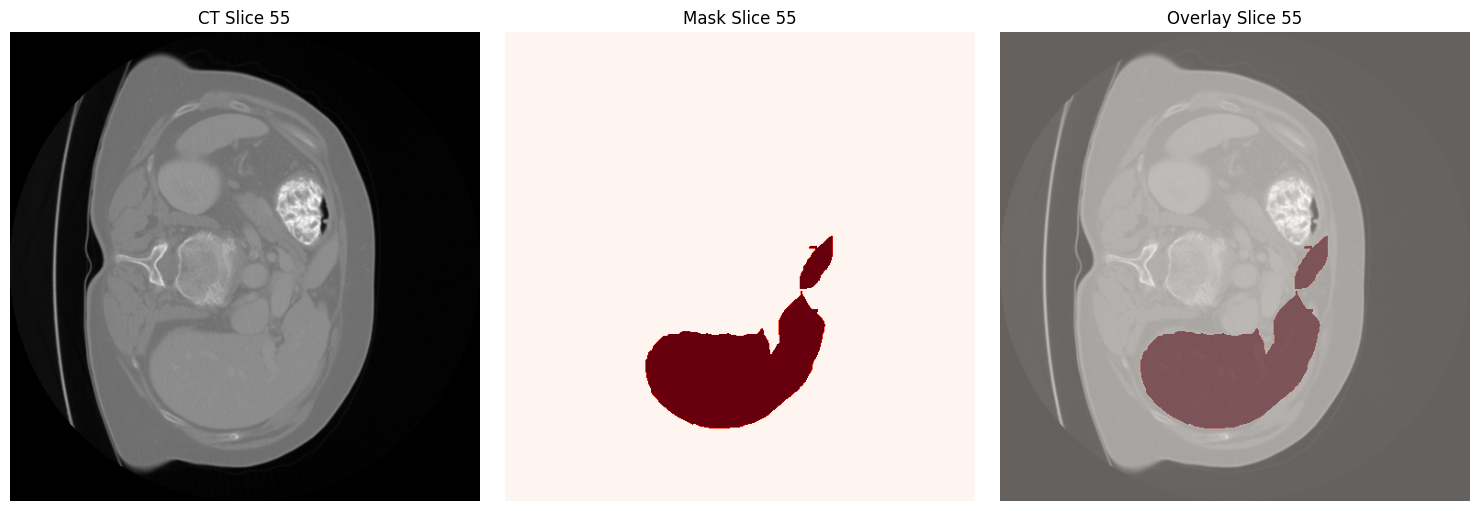

In [8]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

image_path = '/home/mirza-mohammad-azwad/Documents/Research/data/0Liver/imagesTr/liver_0.nii.gz'
mask_path = '/home/mirza-mohammad-azwad/Documents/Research/data/0Liver/labelsTr/liver_0.nii.gz'

img = nib.load(image_path).get_fdata()
mask = nib.load(mask_path).get_fdata()

assert img.shape == mask.shape, f"Shape mismatch: {img.shape} vs {mask.shape}"


slice_index = 55
image_slice = img[:, :, slice_index]
mask_slice = mask[:, :, slice_index]


fig, axes = plt.subplots(1, 3, figsize=(15, 5))


axes[0].imshow(image_slice, cmap='gray')
axes[0].set_title(f'CT Slice {slice_index}')
axes[0].axis('off')


axes[1].imshow(mask_slice, cmap='Reds')
axes[1].set_title(f'Mask Slice {slice_index}')
axes[1].axis('off')

axes[2].imshow(image_slice, cmap='gray')
axes[2].imshow(mask_slice, cmap='Reds', alpha=0.4)
axes[2].set_title(f'Overlay Slice {slice_index}')
axes[2].axis('off')

plt.tight_layout()
plt.show()


## Free CUDA Memory


In [8]:
torch.cuda.empty_cache()

## Training Pipeline


In [9]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn, optim


def dice_score(pred, target, epsilon=1e-6):
    pred = (pred > 0.5).float()
    target = target.float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2. * intersection + epsilon) / (union + epsilon)


class LiverCTDataset(Dataset):
    def __init__(self, image_dir, mask_dir, slice_index=55, transform=None):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.nii.gz')])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.nii.gz')])
        self.slice_index = slice_index
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = nib.load(self.image_paths[idx]).get_fdata()
        mask = nib.load(self.mask_paths[idx]).get_fdata()

        image_slice = image[:, :, self.slice_index]
        mask_slice = mask[:, :, self.slice_index]

        # Normalize to [0,1]
        image_slice = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice) + 1e-8)

        # Add channel dimension
        image_slice = np.expand_dims(image_slice, axis=0)
        mask_slice = np.expand_dims(mask_slice, axis=0)

        if self.transform:
            image_slice = self.transform(image_slice)
            mask_slice = self.transform(mask_slice)

        return torch.tensor(image_slice, dtype=torch.float32), torch.tensor(mask_slice, dtype=torch.float32)


def visualize_prediction(image, mask, prediction, slice_index):
    image = image.squeeze().cpu().numpy()
    mask = mask.squeeze().cpu().numpy()
    prediction = prediction.squeeze().detach().cpu().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title(f'CT Slice {slice_index}')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='Reds')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    axes[2].imshow(image, cmap='gray')
    axes[2].imshow(prediction > 0.5, cmap='Blues', alpha=0.5)
    axes[2].set_title('Model Prediction Overlay')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


def main():
    # Paths
    image_dir = '/home/mirza-mohammad-azwad/Documents/Research/data/0Liver/imagesTr'
    mask_dir = '/home/mirza-mohammad-azwad/Documents/Research/data/0Liver/labelsTr'

    # Hyperparameters
    slice_index = 55
    batch_size = 1
    num_epochs = 10
    learning_rate = 1e-4

    # Dataset & Loader
    dataset = LiverCTDataset(image_dir, mask_dir, slice_index)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Model
    model = UNet_Attention_Transformer_Multiscale(n_channels=1, n_classes=1).cuda()

    # Loss and Optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training Loop
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for image, mask in dataloader:
            image, mask = image.cuda(), mask.cuda()
            optimizer.zero_grad()
            output = torch.sigmoid(model(image))
            loss = criterion(output, mask)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.4f}")
        torch.cuda.empty_cache()

    # Save trained model
    torch.save(model.state_dict(), 'transattunet_trained.pth')
    model.eval()

    # Evaluation
    dice_scores = []
    for image, mask in dataloader:
        image, mask = image.cuda(), mask.cuda()
        with torch.no_grad():
            output = torch.sigmoid(model(image))

        score = dice_score(output, mask)
        dice_scores.append(score.item())

        # Visualize only first example
        visualize_prediction(image[0], mask[0], output[0], slice_index)
        break

    mean_dice = np.mean(dice_scores)
    print(f"Mean Dice Score (Slice {slice_index}): {mean_dice:.4f}")

In [ ]:
main()